In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import xarray as xr
import netCDF4 as nc

di = '/home/claire/Github-forked/MOM6-examples/ocean_only/seamount/simple'

NHALO = 4
IC_FILE = 'MOM_IC.nc'
SHELF_IC_FILE = 'MOM_Shelf_IC.nc'
PROG_FILE = 'prog.nc'
ICE_SHELF_FILE = '/INPUT/shelfX.nc'
TOPO_FILE = '/INPUT/topogX.nc'
THICKNESS_FILE='/INPUT/thickness.nc'

In [2]:
def make_shelf(filename):
    new_shelf = nc.Dataset(filename, "w", format="NETCDF4")
    new_shelf.createDimension("ny", 40)
    new_shelf.createDimension("nx", 240)
    new_shelf.createVariable("thick","f8",("ny","nx"))

    new_shelf.createVariable("area","f8",("ny","nx"))

    x = np.arange(240)
    b1 = np.maximum(350-350*x/125,50)
    b2 = 4000000*np.ones(240)
    zero_positions = np.where(b1==0)[0]
    b2[zero_positions]=0 # Grosfeld 2, comment out for Grosfeld 1
    
    for ii in range(40):
        new_shelf["area"][ii,:] = b2
        new_shelf["thick"][ii,:] = b1

    new_shelf.close()

In [3]:
def make_topography(filename):
    new_topog = nc.Dataset(di + "/INPUT/topogX.nc", "w", format="NETCDF4")
    new_topog.createDimension("ny", 40)
    new_topog.createDimension("nx", 240)
    new_topog.createVariable("depth","f8",("ny","nx"))

    x = np.arange(240)
    b4 = np.minimum(1.7*x+500, 700)
    for ii in range(40):
        new_topog["depth"][ii,:] = b4
    
    new_topog.close()

In [4]:
### new thickness file for THICKNESS_CONFIG="thickness_file"
### depends on MOM6 output in IC_FILE
def make_thickness_file(filename):
    
    ic = xr.open_dataset(di + '/' + IC_FILE)
    _, nz, ny, nx = ic.h.data.shape

    new_thick = nc.Dataset(filename, "w", format="NETCDF4")
    new_thick.createDimension("nz", nz)
    new_thick.createDimension("ny", ny)
    new_thick.createDimension("nx", nx)
    new_thick.createVariable("h","f8",("nz","ny","nx"))

    new_thick["h"][:,:,:] = ic.h.data
    new_thick.close()

In [5]:
### 3D depiction of topography and ice shelf
### depends on MOM6 output in IC_FILE and SHELF_IC_FILE
def display_config():
    
    ic = xr.open_dataset(di + "/"+ IC_FILE)
    ms = xr.open_dataset(di + "/" + SHELF_IC_FILE)
    #ms = xr.open_dataset(di + "/" + ICE_SHELF_FILE)
    #tp = xr.open_dataset(di + "/" + TOPO_FILE)

    LY, LX = ic.h.data[0].shape[1], ic.h.data[0].shape[2]
    YY= np.arange(0, LY, 1)
    XX = np.arange(0, LX, 1)
    XX, YY = np.meshgrid(XX, YY)

    fig, axes = plt.subplots(nrows = 1, ncols=2, figsize = (10,4), subplot_kw={"projection": "3d"})

    surf = axes[0].plot_surface(XX, YY, ms.h_shelf.data[0])
    #surf = axes[0].plot_surface(XX, YY, ms.thick.data)
    axes[0].set_title("Input ICE SHELF h")

    eta = ic.eta[0].data[0]
    bathyT = eta - np.sum(ic.h[0].data, axis=0)

    axes[1].plot_surface(XX, YY, eta)
    axes[1].plot_surface(XX, YY, bathyT)
    #topo2 = axes[1].plot_surface(XX, YY, -tp.depth.data)

    axes[1].set_title("Initial TOPOGRAPHY and ICE SHELF")

    ms.close()
    ic.close()

In [11]:
#make_shelf(di + ICE_SHELF_FILE)
#make_topography(di + TOPO_FILE)
make_thickness_file(di + THICKNESS_FILE)

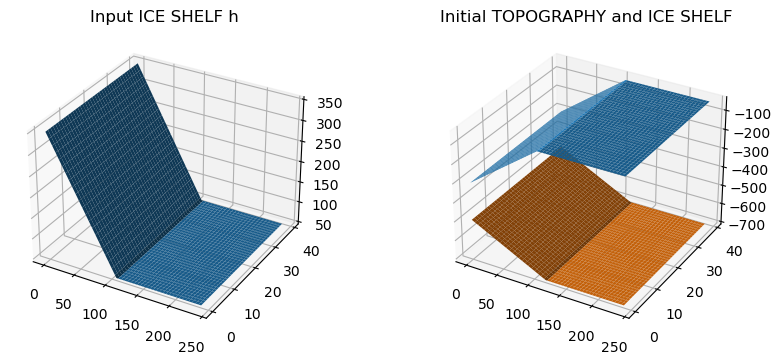

In [7]:
display_config()

### Plot output h,e,salt etc at chosen time

Text(0.5, 0.98, 'Run ends at 0001-01-06 00:00:00')

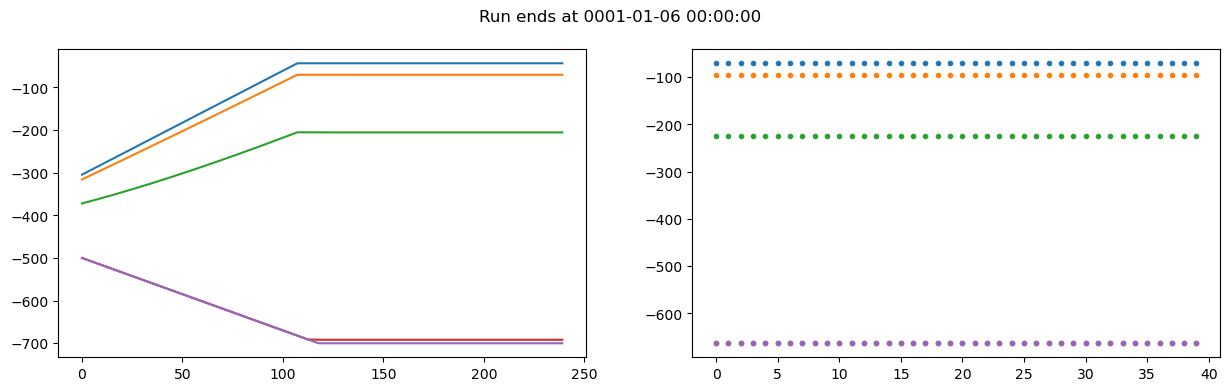

In [12]:
prog = xr.open_dataset(di + '/'+PROG_FILE)
last_time = prog.coords["Time"].values[-1]
     
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4))
tt=-1; zz= 6; yy=6; xx=96; ll = [0,1,zz,-2,-1] # ll=[0,1,2,3,4,5,10,-3,-2,-1]
for zzz in ll:
    axes[0].plot(prog.e[tt][zzz].data[yy,:])
    axes[1].plot(prog.e[tt][zzz].data[:,xx],'.')
fig.suptitle("Run ends at {}".format(last_time))

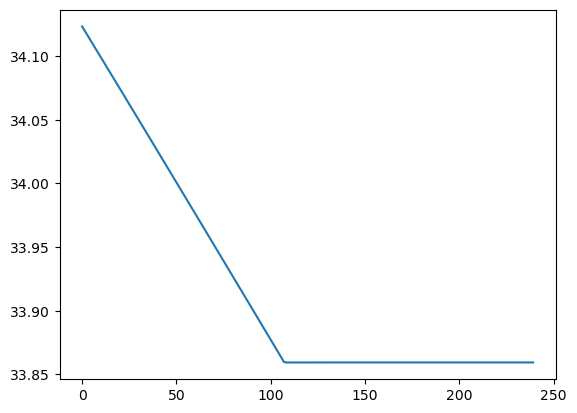

In [13]:
### Can see that the initial salt is "bad" with THICKNESS_CONFIG="ISOMIP" but "fixed" with THICKNESS_CONFIG="thickness_file" hack
ttt = -1; zzz = 0
plt.plot(prog.salt.data[ttt][zzz][yy,:])

In [14]:
print(np.nanmax(prog.u.data[-1]), np.nanmin(prog.u.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

1.1061817587406e-05 -9.019950349067402e-07


In [10]:
print(np.nanmax(prog.v.data[-1]), np.nanmin(prog.v.data[-1])) # 0.0012509557073082142 -0.0006301157530793094

6.026870613570564e-05 -6.026870613570564e-05


In [15]:
arr = prog.u.data[-1]
ind = np.unravel_index(np.nanargmax(arr),arr.shape)
print(arr[ind])
ind

1.1061817587406e-05


(22, 0, 89)

In [16]:
np.nanmin(prog.e.data[0])

-700.0

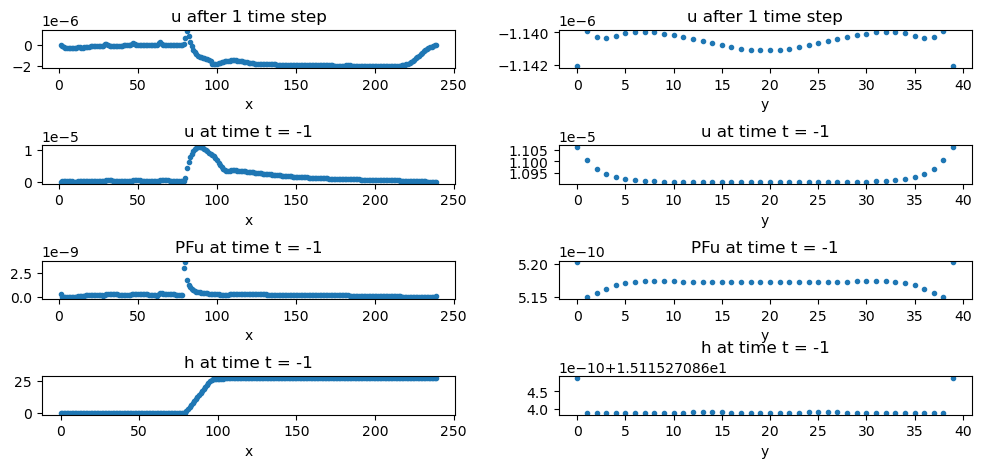

In [19]:
mo = xr.open_dataset(di + '/mom.nc')
fig,axes = plt.subplots(nrows = 4, ncols = 2, figsize = (12,5))

tt=-1; zz=22; yy=0; xx=89
showU = True
if (showU):
    u_or_v = "u"; PFu_or_v = "PFu"; prog_field = prog.u; mo_field = mo.PFu
else:
    u_or_v = "v"; PFu_or_v = "PFv"; prog_field = prog.v; mo_field = mo.PFv
    
axes[0,0].plot(prog_field[0][zz].data[yy,:],'.')
axes[0,0].set_xlabel("x")
axes[0,0].set_title("{} after 1 time step".format(u_or_v)) # depends on diag_table setting
axes[0,1].plot(prog_field[0][zz].data[:,xx],'.')
axes[0,1].set_xlabel("y")
axes[0,1].set_title("{} after 1 time step".format(u_or_v)) # depends on diag_table setting
axes[1,0].plot(prog_field[tt][zz].data[yy,:],'.',)
axes[1,0].set_xlabel("x")
axes[1,0].set_title("{} at time t = {}".format(u_or_v, tt))
axes[1,1].plot(prog_field[tt][zz].data[:,xx],'.')
axes[1,1].set_xlabel("y")
axes[1,1].set_title("{} at time t = {}".format(u_or_v,tt))
axes[2,0].plot(mo_field[tt][zz].data[yy,:],'.')
axes[2,0].set_xlabel("x")
axes[2,0].set_title("{} at time t = {}".format(PFu_or_v,tt))
axes[2,1].plot(mo_field[tt][zz].data[:,xx],'.',)
axes[2,1].set_xlabel("y")
axes[2,1].set_title("{} at time t = {}".format(PFu_or_v, tt))
axes[3,0].plot(prog.h[tt][zz].data[yy,:],'.')
axes[3,0].set_xlabel("x")
axes[3,0].set_title("h at time t = {}".format(tt))
axes[3,1].plot(prog.h[tt][zz].data[:,xx],'.',)
axes[3,1].set_xlabel("y")
axes[3,1].set_title("h at time t = {}".format(tt))

plt.subplots_adjust(wspace = 0.25, hspace = 2.0)

mo.close()

In [ ]:
#!aft = xr.open_dataset(di + '/after_ts_2_u.nc') # works only for 1 core, shows u after 1 time step
mo = xr.open_dataset(di + '/mom.nc')

fig,axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15,4))

tt=0; zz=1; yy=0; xx=164
#!axes[0,0].plot(aft.u.data[zzz,yy+NHALO,NHALO:-NHALO])
axes[0,0].plot(prog.u[0][zz].data[yy,:])
axes[0,0].set_xlabel("x")
axes[0,0].set_title("u at first output time") # depends on diag_table setting
#!axes[0,1].plot(aft.u.data[zzz,NHALO:-NHALO,xx+NHALO],'o')
axes[0,1].plot(prog.u[0][zz].data[:,xx])
axes[0,1].set_xlabel("y")
axes[0,1].set_title("u at first output time") # depends on diag_table setting
axes[1,0].plot(prog.u[tt][zz].data[yy,:])
axes[1,0].set_xlabel("x")
axes[1,0].set_title("u at time t = {}".format(tt))
axes[1,1].plot(prog.u[tt][zz].data[:,xx])
axes[1,1].set_xlabel("y")
axes[1,1].set_title("u at time t = {}".format(tt))
axes[2,0].plot(mo.PFu[tt][zz].data[yy,:])
axes[2,0].set_xlabel("x")
axes[2,0].set_title("PFu at time t = {}".format(tt))
axes[2,1].plot(mo.PFu[tt][zz].data[:,xx])
axes[2,1].set_xlabel("y")
axes[2,1].set_title("PFu at time t = {}".format(tt))

plt.subplots_adjust(wspace = 0.25, hspace = 1.2)

### Make an "adjusted salt" file

#! Open files saved by MOM6 needed to adjust the salt 
bt=xr.open_dataset(di + "/deb_bathyT.nc") # topography file needed to calculate e
h=xr.open_dataset(di + '/after_ts_2_h.nc') # h file before the first time step, but after MOM6 remap
S=xr.open_dataset(di + '/before_finish_MOM_initialization_S.nc') # salt file produced by MOM6, which we want to adjust 

#! calculate e and then s as a linear function of e 
S_TOP = 33.8
S_BOTTOM = 34.55
MAXIMUM_DEPTH = 720.0
e=h.h.sum(axis=0).data-bt.bathyT.data
s=(e-h.h.data.cumsum(axis=0) + h.h.data/2)*(S_BOTTOM-S_TOP)/(-MAXIMUM_DEPTH) + S_TOP

#! fix the halo points
s[:,:NHALO,:NHALO]=0
s[:,:NHALO,-NHALO:]=0
s[:,-NHALO:,:NHALO]=0
s[:,-NHALO:,-NHALO:]=0

#! create new netcdf4 file for the adjusted salt based on the original salt file
nz, ny, nx = S.S.data.shape
new_salt = nc.Dataset(di + "/INPUT/adjustedS.nc", "w", format="NETCDF4")
new_salt.createDimension("nz", nz)
new_salt.createDimension("ny", ny)
new_salt.createDimension("nx", nx)
temp = new_salt.createVariable("S","f8",("nz","ny","nx"))
temp[:,:,:]=s
new_salt.close()

### Make new  topography and ice shelf files, if necessary

### Some diagnostics trying to understand when h changed during MOM_initialization()
h0=xr.open_dataset(di + '/INPUT/thickness.nc')

h01=xr.open_dataset(di + '/after_alloc_h.nc')
h02=xr.open_dataset(di + '/before_use_frazil_check_h.nc')
h03=xr.open_dataset(di + '/before_restart_init_h.nc')
h04=xr.open_dataset(di + '/before_ALE_init_h.nc')
h05=xr.open_dataset(di + '/before_use_ice_shelf_check_h.nc')
h1=xr.open_dataset(di + '/before_MOM_initialize_state_h.nc') # strange?  <---------  What's this?

#! call MOM_initialize_state()
h2=xr.open_dataset(di + '/after_initialize_thickness_h.nc') # same as h0

#h3=xr.open_dataset(di + '/after_sfc_disp_h.nc') #(bottom no longer flat!!!)  <------ What happened? (HACK_MODE fixes this)
h4=xr.open_dataset(di + '/after_MOM_initialize_state_h.nc') # same as h3
h5=xr.open_dataset(di + '/after_ts_0_h.nc') # same as h3

h6=xr.open_dataset(di + '/after_ts_2_h.nc')



### More diagnostics

bt=xr.open_dataset(di + "/deb_bathyT.nc") # topography file needed to calculate e
h=xr.open_dataset(di + '/INPUT/thickness.nc') # h file before the first time step, but after MOM6 remap
e2=h01.h.sum(axis=0).data[4:-4,4:-4]-bt.bathyT.data[4:-4,4:-4]
#e2=h0.h.sum(axis=0).data-bt.bathyT.data[4:-4,4:-4]
e3=e2-h.h.data.cumsum(axis=0)

fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4))
tt=0; yy=10; ll=[0,1,2,3,4,5,10,-3,-2,-1]
for zzz in ll:
    axes[0].plot(e3[zzz,yy,:])